## Data Import

DataDriven provided code for using variable mapping and applying it to the primary dataset

In [1]:
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from num2words import num2words
from rake_nltk import Rake

In [2]:
with Path("Data/variable_mapping.json").open("r") as f:
    mapping = json.load(f, parse_int=True)

In [3]:
# convert the encoded values in the mapping to integers since they get read in as strings
for c in mapping.keys():
    mapping[c] = {int(k): v for k, v in mapping[c].items()}

In [4]:
# the keys in the dictionary correspond to columns in the primary (and supplementary) data
mapping.keys()

dict_keys(['sex', 'race', 'hispanic', 'alcohol', 'drug', 'body_part', 'body_part_2', 'diagnosis', 'diagnosis_2', 'disposition', 'location', 'fire_involvement', 'product_1', 'product_2', 'product_3'])

In [5]:
df = pd.read_csv(
    "Data/primary_data.csv",
    # set columns that can be null to nullable ints
    dtype={"body_part_2": "Int64", "diagnosis_2": "Int64"},
)
df.head()

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,...,body_part,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3
0,190103269,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...,2019-01-01,94,1,0,NaN,0,62,NaN,...,75,<NA>,4,5,0,0,0,1807,0,0
1,190103270,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...,2019-01-01,86,1,0,NaN,0,62,NaN,...,75,<NA>,4,1,0,0,0,611,0,0
2,190103273,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...,2019-01-01,87,2,0,NaN,0,53,NaN,...,32,<NA>,4,1,0,0,0,679,1807,0
3,190103291,67YOF WAS AT A FRIENDS HOUSE AND SLIPPED ON WA...,2019-01-01,67,2,0,NaN,0,57,NaN,...,33,<NA>,1,1,0,0,0,1807,0,0
4,190103294,70YOF WAS STANDING ON A STEP STOOL AND FELL OF...,2019-01-01,70,2,0,NaN,0,57,NaN,...,33,<NA>,1,1,0,0,0,620,0,0


In [6]:
decoded_df = df.copy()

for col in mapping.keys():
    decoded_df[col] = decoded_df[col].map(mapping[col])

In [7]:
decoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115128 entries, 0 to 115127
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   cpsc_case_number   115128 non-null  int64 
 1   narrative          115128 non-null  object
 2   treatment_date     115128 non-null  object
 3   age                115128 non-null  int64 
 4   sex                115128 non-null  object
 5   race               115128 non-null  object
 6   other_race         1022 non-null    object
 7   hispanic           115128 non-null  object
 8   diagnosis          115128 non-null  object
 9   other_diagnosis    2522 non-null    object
 10  diagnosis_2        43145 non-null   object
 11  other_diagnosis_2  4978 non-null    object
 12  body_part          115128 non-null  object
 13  body_part_2        43145 non-null   object
 14  disposition        115128 non-null  object
 15  location           115128 non-null  object
 16  fire_involvement   1

## Exploratory Data Analysis

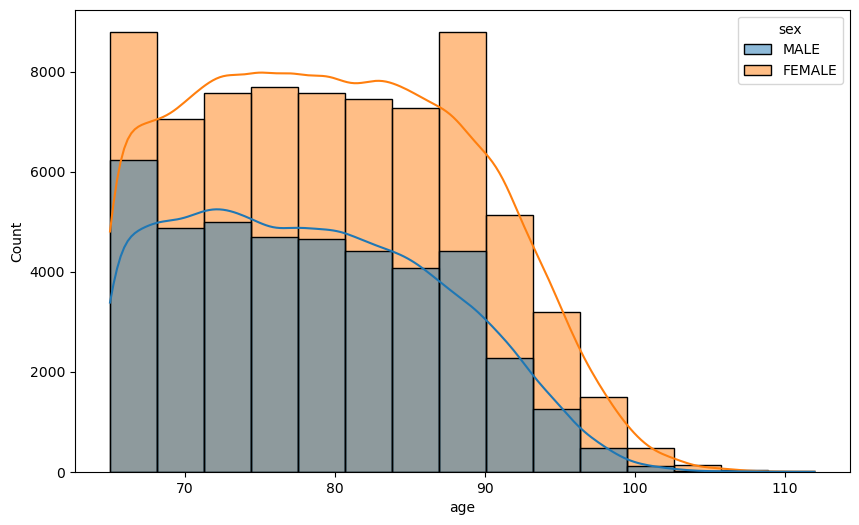

In [12]:
plt.figure(figsize = (10,6))
sns.histplot(data = decoded_df, x = 'age', bins = 15, hue = 'sex', kde = True);

Sample population contains more females than males and is not normally distributed. Mean age is somewhere in the 80s.

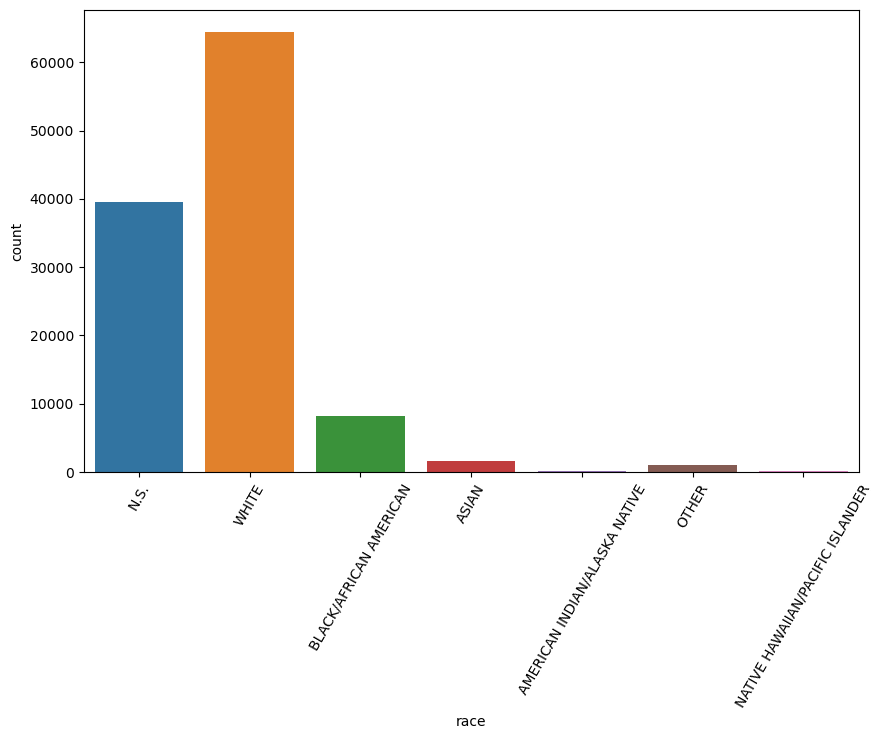

In [13]:
plt.figure(figsize = (10,6))
sns.countplot(data = decoded_df, x = 'race')
plt.xticks(rotation=60);

Primarily white patients. A large number of individuals have N.S. as their primary race, which I will assume to mean not stated.

## Preprocessing for NLP

The goal of the NLP task is to extract additional insights about elderly falls not captured in the 

What needs to happen before the narrative data can be analyzed?
* lower case
* remove stopwords, punctuation and special characters
* remove age and sex
* remove reference to falls
* attempt to replace any abbreviations with medical definitions
* remove any medical terms present in the diagnosis column

In [14]:
medical_terms = {
    "&": "and",
    "***": "",
    ">>": "clinical diagnosis",
    "@": "at",
    "abr": "abrasion",
    "abd": "abdomen",
    "af": "accidental fall",
    "afib": "atrial fibrillation",
    "aki": "acute kidney injury",
    "am": "morning",
    "ams": "altered mental status",
    "bac": "blood alcohol content",
    "bal": "blood alcohol level,",
    "biba": "brought in by ambulance",
    "c/o": "complains of",
    "chi": "closed-head injury",
    "clsd": "closed",
    "cpk": "creatine phosphokinase",
    "cva": "cerebral vascular accident",
    "dx": "diagnosis",
    "ecf": "extended-care facility",
    "er": "emergency room",
    "etoh": "ethyl alcohol",
    "eval": "evaluation",
    "fd": "fall detected",
    "fx": "fracture",
    "fxs": "fractures",
    "glf": "ground level fall",
    "h/o": "history of",
    "htn": "hypertension",
    "hx": "history of",
    "inj": "injury",
    "inr": "international normalized ratio",
    "intox": "intoxication",
    "l": "left",
    "loc": "loss of consciousness",
    "lt": "left",
    "mech": "mechanical",
    "mult": "multiple",
    "n.h.": "nursing home",
    "nh": "nursing home",
    "p/w": "presents with",
    "pm": "afternoon",
    "pt": "patient",
    "pta": "prior to arrival",
    "pts": "patient's",
    "px": "physical examination", # not "procedure",
    "r": "right",
    "r/o": "rules out",
    "rt": "right",
    "s'd&f": "slipped and fell",
    "s/p": "after",
    "sah": "subarachnoid hemorrhage",
    "sdh": "acute subdural hematoma",
    "sts": "sit-to-stand",
    "t'd&f": "tripped and fell",
    "tr": "trauma",
    "uti": "urinary tract infection",
    "w/": "with",
    "w/o": "without",
    "wks": "weeks"
}

In [ ]:
# Download the set of stopwords from NLTK
nltk.download('punkt')
nltk.download('stopwords')

# Load stopwords once
stop_words = set(stopwords.words('english'))

In [57]:
#Define preprocess function for diagnosis terms 

def preprocess_diagnosis(text, medical_dictionary=medical_terms, stop_words=stop_words):
    
    # Convert text to lowercase
    text = text.lower()
    
    # Remove all numbers
    text = re.sub(r'\d+', '', text)

    # Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Replace words using the medical dictionary
    text = ' '.join([medical_dictionary.get(word, word) for word in text.split()])

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    cleaned_text = [word for word in tokens if word not in stop_words]

    return ' '.join(cleaned_text)

In [59]:
decoded_df['processed_diagnosis'] = decoded_df['diagnosis'].apply(
    lambda x: preprocess_diagnosis(x))

In [61]:
# Compile the regular expression pattern for age and gender patterns
age_gender_pattern = re.compile(r'\b\d+yo?m\b|\b\d+yo?f\b', flags=re.IGNORECASE)

# Define function for preprocessing narratives
def preprocess_text(text, diagnosis_terms, medical_dictionary = medical_terms, 
                    pattern=age_gender_pattern, stop_words=stop_words):
    
    # Remove age and gender patterns captured in other features
    text = pattern.sub('', text)
    
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Replace words using the medical dictionary
    text = ' '.join([medical_dictionary.get(word, word) for word in text.split()])

    # Remove variations of the word "fall"
    text = re.sub(r'\bfalls?\b|\bfell\b|\bfallen\b|\bfalling\b', '', text, flags=re.IGNORECASE)

    # Convert numbers to words
    text = ' '.join([num2words(word) if word.isdigit() else word for word in text.split()])

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords and words found in diagnosis
    cleaned_text = [word for word in tokens if word not in stop_words and word not in diagnosis_terms.lower()]

    return ' '.join(cleaned_text)

In [63]:
# apply preprocessing function to narratives
decoded_df['processed_narrative'] = decoded_df.apply(
    lambda row: preprocess_text(row['narrative'], row['processed_diagnosis']), axis=1)

In [64]:
print(decoded_df['processed_narrative'].head(5).values)

['floor nursing home onto back head sustained subdural hematoma'
 'shower home sustained closed head'
 'getting couch floor sustained abrasions elbows admitted hemorrhagic stroke'
 'friends house slipped water floor sustained right radius'
 'standing step stool sustained right radius']


In [66]:
decoded_df['processed_diagnosis'][2]

'contusions abrasion'

In [86]:
decoded_df['diagnosis'].value_counts()

diagnosis
57 - FRACTURE            37125
62 - INTERNAL INJURY     30843
53 - CONTUSIONS, ABR.    19483
59 - LACERATION          12417
64 - STRAIN, SPRAIN       3951
58 - HEMATOMA             3671
71 - OTHER                2522
72 - AVULSION             1845
55 - DISLOCATION          1336
52 - CONCUSSION            937
68 - POISONING             350
61 - NERVE DAMAGE          230
66 - HEMORRHAGE            153
60 - DENTAL INJURY          84
51 - BURNS, THERMAL         54
63 - PUNCTURE               39
48 - BURN, SCALD            19
50 - AMPUTATION             19
56 - FOREIGN BODY           16
74 - DERMA/CONJUNCT         10
54 - CRUSHING                8
42 - ASPIRATION              7
65 - ANOXIA                  3
49 - BURN, CHEMICAL          3
47 - BURN, NOT SPEC.         2
67 - ELECTRIC SHOCK          1
Name: count, dtype: int64

Things you can do:
* find the abbreviations and replace them
* named entity recognition - possibly use LLM to extract better locations than what is recorded in the dataset. Example: nursing home vs home, apartment vs house, park vs sidewalk
* dependency parsing using a simpilfied version of the products list 

## Basic Extraction of Key Phrases

In [81]:
# Initialize RAKE
rake_nltk_var = Rake()

def extract_key_phrases(text):
    rake_nltk_var.extract_keywords_from_text(text)
    key_phrases = rake_nltk_var.get_ranked_phrases()  # Extract key phrases
    return key_phrases

# Apply to your DataFrame
decoded_df['key_phrases'] = decoded_df['processed_narrative'].apply(extract_key_phrases)  # Replace 'preprocessed_text_column' with your column name


In [83]:
print(decoded_df['key_phrases'].head(5).values)

[list(['fell floor nursing home onto back head sustained subdural hematoma'])
 list(['fell shower home sustained closed head injury'])
 list(['getting couch fell floor sustained abrasions elbows admitted hemorrhagic stroke'])
 list(['friends house slipped water floor sustained right radius fx'])
 list(['standing step stool fell sustained right radius fx'])]
